# Experiment 1
Below is the pipline given for the first experiment. The corpus files are first extracted, after which the pre-processing steps are done. The filtered and prepared corpus is saved to be used in the topic modelling algorithm. The orignal corpus is also saved, together with its dictionary and other statistics. The created corpus is then used in some coherence measures and inspected. Based on this is the right amount of topics chosen. This is further analysed, shown and saved. 

## Reading the files

In [187]:
import os
import sys 
sys.path.append('/home/vanwissen/degids/')

from modules.DeGids.DeGids import FoliaCorpus
from modules.DeGids.DeGids import DeGids

from pynlpl.formats import folia

%matplotlib inline
import pandas as pd
from matplotlib2tikz import save as tikz_save

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pickle

In [3]:
from gensim.corpora import MmCorpus
from gensim.models import CoherenceModel, LdaModel, LdaMulticore

2018-09-13 18:46:07,136 : INFO : 'pattern' package not found; tag filters are not available for English


In [4]:
CORPUS = "/mnt/scistor1/group/home/vanwissen/degids_1837_1936/"
METAFILES = "/home/vanwissen/degids/data/metadata_auteursinformatie/"

### Corpus without entities stuck together

In [5]:
corpus = FoliaCorpus(corpuspath=CORPUS,
                     metafiles=METAFILES, 
                     dictionary=None, 
                     years=(1848, 1848), 
                     lemma=True, 
                     add_entities=False, 
                     remove_stopwords=True, 
                     stopwordsfile='../../data/stoplist_dutch.txt',  
                     remove_accents=True, 
                     remove_nonalpha=True, 
                     remove_punctuation=True, 
                     remove_hyphenation=True, 
                     remove_apostrophe=True, 
                     transform_lowercase=True,
                     gzipped=False
                    )

2018-09-13 18:10:28,358 : INFO : Initializing dictionary
2018-09-13 18:10:28,359 : INFO : Quering texts from 1848-1848
2018-09-13 18:10:28,462 : INFO : Reading _gid001184801_01_0001 (1848) Karel Hendrik Ver Huell en Rutger Jan Schimmelpenninck.
2018-09-13 18:10:36,390 : INFO : Reading _gid001184801_01_0002 (1848) Geregtelijke Geneeskunde.
2018-09-13 18:10:41,863 : INFO : Reading _gid001184801_01_0003 (1848) Westminster en St. Pauls.
2018-09-13 18:10:44,846 : INFO : Reading _gid001184801_01_0004 (1848) Een sneeuwstorm in de Hooglanden. Uitspanningen van Christopher North.
2018-09-13 18:10:49,745 : INFO : Reading _gid001184801_01_0005 (1848) Te Delft, in October 1847.
2018-09-13 18:10:51,121 : INFO : Reading _gid001184801_01_0006 (1848) Staatkundig overzigt.
2018-09-13 18:10:54,777 : INFO : Reading _gid001184801_01_0007 (1848) Bijbelsche Aardrijkskunde.
2018-09-13 18:11:08,461 : INFO : Reading _gid001184801_01_0008 (1848) Geregtelijke Geneeskunde.


KeyboardInterrupt: 

In [ ]:
corpus.statistics

#### Filtering

In [ ]:
corpus.filter(min_dfs=1, max_dfs=0.8, min_tfs=2)

In [ ]:
corpus.statistics

#### Saving

In [ ]:
corpus.serialize('1848')

In [ ]:
ls

### Corpus with entities stuck together

In [ ]:
corpus_entity = FoliaCorpus(corpuspath=CORPUS,
                            metafiles=METAFILES, 
                            dictionary=None, 
                            years=(1848, 1848), 
                            lemma=True, 
                            add_entities=True, 
                            remove_stopwords=True, 
                            stopwordsfile='../../data/stoplist_dutch.txt',  
                            remove_accents=True, 
                            remove_nonalpha=True, 
                            remove_punctuation=True, 
                            remove_hyphenation=True, 
                            remove_apostrophe=True, 
                            transform_lowercase=True,
                            gzipped=False
                           )

In [ ]:
corpus_entity.statistics

#### Filtering

In [ ]:
corpus_entity.filter(min_dfs=1, max_dfs=0.8, min_tfs=2)

In [ ]:
corpus_entity.statistics

#### Saving

In [ ]:
corpus_entity.serialize('1848_entity')

In [2]:
ls

1848_entity.foliacorpus     1848_topic_list_20ent.tex
1848_entity.mmcorpus        1848_topic_list_20.tex
1848_entity.mmcorpus.index  1848_topic_list_30ent.tex
1848.foliacorpus            1848_topic_list_30.tex
1848.ipynb                  1848_topic_list_50ent.tex
1848.mmcorpus               1848_topic_list_50.tex
1848.mmcorpus.index         experiment1coherence.tikz
1848_topic_list_100ent.tex  images/
1848_topic_list_100.tex


## Loading the mmCorpora

In [5]:
mcorpus = MmCorpus('1848.mmcorpus')

with open('1848.foliacorpus', 'rb') as picklefile:
    corpus = pickle.load(picklefile)

2018-09-13 18:46:15,575 : INFO : loaded corpus index from 1848.mmcorpus.index
2018-09-13 18:46:15,580 : INFO : initializing cython corpus reader from 1848.mmcorpus
2018-09-13 18:46:15,582 : INFO : accepted corpus with 72 documents, 14109 features, 82366 non-zero entries


In [6]:
mcorpus_entity = MmCorpus('1848_entity.mmcorpus')

with open('1848_entity.foliacorpus', 'rb') as picklefile:
    corpus_entity = pickle.load(picklefile)

2018-09-13 18:46:16,349 : INFO : loaded corpus index from 1848_entity.mmcorpus.index
2018-09-13 18:46:16,351 : INFO : initializing cython corpus reader from 1848_entity.mmcorpus
2018-09-13 18:46:16,353 : INFO : accepted corpus with 72 documents, 13863 features, 80617 non-zero entries


## Choosing the right amount of topics

### Coherence

In [18]:
def get_coherences(mmcorpus, dictionary, n_topics=[]):
    coherences = []
    models = []
    
    for k in n_topics:
        # Build a topic model
        lda_model = LdaModel(corpus=mmcorpus, 
                             num_topics=k, 
                             id2word=dictionary, 
#                              chunksize=40, 
                             passes=20, 
                             alpha='auto', 
                             eta=None, 
                             eval_every=10, 
                             iterations=50,
                             random_state=2018
                            )
        
        # For this model, build a coherence model
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             corpus=mmcorpus, 
                                             dictionary=dictionary, 
                                             coherence='u_mass')
        
        # Add coherence to list
        coherence = coherence_model_lda.get_coherence()
        coherences.append((k,coherence))
        
        models.append((k,lda_model))
        
    return dict(coherences), models

In [ ]:
n_topics = range(10, 210, 10)
coherences_1848, models_1848 = get_coherences(mcorpus, corpus.dictionary, n_topics)
coherences_1848_entity, models_1848_entity = get_coherences(mcorpus_entity, corpus_entity.dictionary, n_topics)

#### Visualise this in some graph

In [20]:
df = pd.DataFrame({'1848': coherences_1848, '1848_entity': coherences_1848_entity})

Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec} % This line only for XeLaTeX and LuaLaTeX
\usepackage{pgfplots}
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


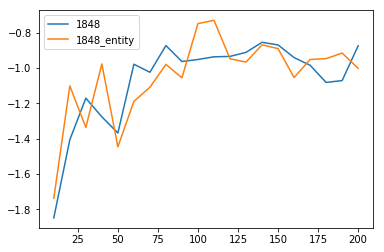

In [21]:
df.plot()
tikz_save('experiment1coherence.tikz',
           figureheight = '\\figureheight',
           figurewidth = '\\figurewidth')

Altering just the slidest bit to the settings above already yields a totally different graph. I am not using this method. 

Pick some models for inspection. Below are the models pointed to a variable, this is inputted in a function that generates a LaTex display of the topics that can be imported in the thesis easily. 

In [207]:
def get_model(k, mcorpus, fcorpus, filename=""):
    """
    """
    
    # Build a topic model
    lda_model = LdaModel(corpus=mcorpus, 
                         num_topics=k, 
                         id2word=fcorpus.dictionary, 
#                        chunksize=40, 
                         passes=20, 
                         alpha='auto', 
                         eta=None, 
                         eval_every=10, 
                         iterations=50,
                         random_state=2018,
                        )
    
    lda_model.save(filename)
    
    return lda_model

In [208]:
model30ent = get_model(30, mcorpus_entity, corpus_entity, filename="1848_30_ent.model")

2018-09-17 15:25:24,435 : INFO : using autotuned alpha, starting with [0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335, 0.033333335]
2018-09-17 15:25:24,437 : INFO : using symmetric eta at 0.03333333333333333
2018-09-17 15:25:24,441 : INFO : using serial LDA version on this node
2018-09-17 15:25:24,527 : INFO : running online (multi-pass) LDA training, 30 topics, 20 passes over the supplied corpus of 72 documents, updating model once every 72 documents, evaluating perplexity every 72 documents, iterating 50x with a convergence threshold of 0.001000
2018-09-17 15:25:26,107 : INFO : -15.057 per-word bound, 34077.5 perplexity estimate based on a held-out corpus of 72

2018-09-17 15:25:32,809 : INFO : PROGRESS: pass 4, at document #72/72
2018-09-17 15:25:33,062 : INFO : optimized alpha [0.032026067, 0.030143565, 0.03128755, 0.0294539, 0.030933946, 0.02955016, 0.03413194, 0.040563677, 0.029380908, 0.04270308, 0.030734407, 0.048985757, 0.031517148, 0.03169339, 0.033801943, 0.051278654, 0.033314995, 0.030734332, 0.07980002, 0.03241584, 0.029837165, 0.03549581, 0.03239664, 0.03174191, 0.029671583, 0.046143264, 0.036989074, 0.031470515, 0.030347062, 0.028998312]
2018-09-17 15:25:33,140 : INFO : topic #29 (0.029): 0.001*"oud" + 0.001*"volk" + 0.001*"naam" + 0.001*"koning" + 0.001*"taal" + 0.001*"staat" + 0.001*"stelsel" + 0.001*"zaak" + 0.001*"werk" + 0.001*"schrijven"
2018-09-17 15:25:33,141 : INFO : topic #8 (0.029): 0.003*"naam" + 0.003*"kaart" + 0.003*"stad" + 0.002*"gebergte" + 0.002*"moab" + 0.002*"heer" + 0.002*"werk" + 0.002*"num" + 0.002*"senden" + 0.002*"woestijn"
2018-09-17 15:25:33,142 : INFO : topic #11 (0.049): 0.008*"god" + 0.005*"mensch" + 

2018-09-17 15:25:39,334 : INFO : topic #15 (0.044): 0.008*"arbeid" + 0.006*"belasting" + 0.006*"stelsel" + 0.006*"kapitaal" + 0.005*"maatschappij" + 0.005*"mensch" + 0.005*"beginsel" + 0.004*"paulus" + 0.004*"wet" + 0.004*"denkbeeld"
2018-09-17 15:25:39,336 : INFO : topic #11 (0.045): 0.009*"god" + 0.006*"mensch" + 0.005*"werk" + 0.005*"geest" + 0.005*"opvoeding" + 0.004*"ontwikkeling" + 0.004*"volk" + 0.004*"geschiedenis" + 0.004*"hart" + 0.004*"denkbeeld"
2018-09-17 15:25:39,339 : INFO : topic #18 (0.081): 0.004*"koning" + 0.004*"volk" + 0.004*"vorst" + 0.003*"minister" + 0.003*"frankrijk" + 0.003*"staat" + 0.003*"stad" + 0.003*"vergadering" + 0.003*"zaak" + 0.003*"regering"
2018-09-17 15:25:39,341 : INFO : topic diff=0.780150, rho=0.316228
2018-09-17 15:25:40,641 : INFO : -8.671 per-word bound, 407.6 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-17 15:25:40,642 : INFO : PROGRESS: pass 9, at document #72/72
2018-09-17 15:25:41,248 : INFO : o

2018-09-17 15:25:50,552 : INFO : optimized alpha [0.019920783, 0.017895725, 0.018949114, 0.017030366, 0.018183015, 0.017688025, 0.022486947, 0.029107446, 0.017458687, 0.030575514, 0.01870235, 0.04387402, 0.018997494, 0.020214561, 0.022926658, 0.04018131, 0.021587221, 0.018801183, 0.08088828, 0.020230692, 0.01911619, 0.02265046, 0.020762736, 0.019762158, 0.01777376, 0.033742957, 0.025273394, 0.018993717, 0.0180051, 0.016882602]
2018-09-17 15:25:50,683 : INFO : topic #29 (0.017): 0.000*"oud" + 0.000*"volk" + 0.000*"naam" + 0.000*"koning" + 0.000*"taal" + 0.000*"staat" + 0.000*"stelsel" + 0.000*"zaak" + 0.000*"werk" + 0.000*"schrijven"
2018-09-17 15:25:50,684 : INFO : topic #3 (0.017): 0.000*"koning" + 0.000*"stad" + 0.000*"naam" + 0.000*"zaak" + 0.000*"wetenschap" + 0.000*"arbeid" + 0.000*"staat" + 0.000*"lid" + 0.000*"beginsel" + 0.000*"wet"
2018-09-17 15:25:50,686 : INFO : topic #15 (0.040): 0.009*"arbeid" + 0.007*"belasting" + 0.007*"kapitaal" + 0.006*"stelsel" + 0.006*"maatschappij" 

2018-09-17 15:26:00,911 : INFO : topic #11 (0.043): 0.009*"god" + 0.006*"mensch" + 0.005*"werk" + 0.005*"geest" + 0.005*"opvoeding" + 0.004*"hart" + 0.004*"ontwikkeling" + 0.004*"geschiedenis" + 0.004*"volk" + 0.004*"dier"
2018-09-17 15:26:00,912 : INFO : topic #18 (0.080): 0.004*"koning" + 0.004*"volk" + 0.004*"vorst" + 0.003*"minister" + 0.003*"frankrijk" + 0.003*"staat" + 0.003*"vergadering" + 0.003*"stad" + 0.003*"zaak" + 0.003*"regering"
2018-09-17 15:26:00,914 : INFO : topic diff=0.083746, rho=0.229416
2018-09-17 15:26:02,445 : INFO : -8.593 per-word bound, 386.2 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-17 15:26:02,446 : INFO : PROGRESS: pass 18, at document #72/72
2018-09-17 15:26:03,058 : INFO : optimized alpha [0.01728795, 0.015275675, 0.01629968, 0.014403877, 0.015489579, 0.015123198, 0.020111412, 0.026821945, 0.014707274, 0.027865749, 0.016126886, 0.043361913, 0.016326007, 0.01777386, 0.020441735, 0.03826451, 0.019124474, 0.016

In [22]:
# for when using the coherence model

# model20 = dict(models_1848)[20]
# model20ent = dict(models_1848_entity)[20]

# model30 = dict(models_1848)[30]
# model30ent = dict(models_1848_entity)[30]

# model50 = dict(models_1848)[50]
# model50ent = dict(models_1848_entity)[50]

# model100 = dict(models_1848)[100]
# model100ent = dict(models_1848_entity)[100]


model20 = get_model(20, mcorpus, corpus, filename="1848_20.model")
model20ent = get_model(20, mcorpus_entity, corpus_entity, filename="1848_20_ent.model")

model30 = get_model(30, mcorpus, corpus, filename="1848_30.model")
model30ent = get_model(30, mcorpus_entity, corpus_entity, filename="1848_30_ent.model")

model50 = get_model(50, mcorpus, corpus, filename="1848_50.model")
model50ent = get_model(50, mcorpus_entity, corpus_entity, filename="1848_50_ent.model")

model100 = get_model(100, mcorpus, corpus, filename="1848_100.model")
model100ent = get_model(100, mcorpus_entity, corpus_entity, filename="1848_100_ent.model")

2018-09-13 18:31:51,721 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2018-09-13 18:31:51,723 : INFO : using symmetric eta at 0.05
2018-09-13 18:31:51,728 : INFO : using serial LDA version on this node
2018-09-13 18:31:51,790 : INFO : running online (multi-pass) LDA training, 20 topics, 20 passes over the supplied corpus of 72 documents, updating model once every 72 documents, evaluating perplexity every 72 documents, iterating 50x with a convergence threshold of 0.001000
2018-09-13 18:31:53,046 : INFO : -12.794 per-word bound, 7101.2 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:31:53,047 : INFO : PROGRESS: pass 0, at document #72/72
2018-09-13 18:31:53,294 : INFO : optimized alpha [0.092793986, 0.09248443, 0.08970197, 0.09359193, 0.09260701, 0.08974221, 0.09065596, 0.09151844, 0.088657334, 0.09048271, 0.08930099, 0.0

2018-09-13 18:31:58,375 : INFO : topic #3 (0.055): 0.005*"god" + 0.005*"volk" + 0.004*"vorst" + 0.004*"stad" + 0.003*"mensch" + 0.003*"geschiedenis" + 0.003*"geest" + 0.003*"werk" + 0.003*"hart" + 0.003*"opvoeding"
2018-09-13 18:31:58,377 : INFO : topic #14 (0.055): 0.008*"naam" + 0.007*"heer" + 0.006*"gesticht" + 0.005*"krankzinnig" + 0.004*"oud" + 0.004*"schrijver" + 0.003*"lied" + 0.003*"werk" + 0.003*"bekend" + 0.003*"baalbek"
2018-09-13 18:31:58,380 : INFO : topic #16 (0.067): 0.009*"lid" + 0.008*"vergadering" + 0.007*"koning" + 0.006*"klassikaal" + 0.005*"synode" + 0.005*"kerk" + 0.005*"commissie" + 0.004*"bestuur" + 0.004*"provinciaal" + 0.003*"vertegenwoordigen"
2018-09-13 18:31:58,382 : INFO : topic diff=1.432867, rho=0.408248
2018-09-13 18:31:59,360 : INFO : -8.834 per-word bound, 456.4 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:31:59,361 : INFO : PROGRESS: pass 5, at document #72/72
2018-09-13 18:31:59,544 : INFO : optimize

2018-09-13 18:32:04,427 : INFO : topic #10 (0.021): 0.000*"lid" + 0.000*"naam" + 0.000*"heer" + 0.000*"zaak" + 0.000*"vergadering" + 0.000*"bestuur" + 0.000*"wetenschap" + 0.000*"da" + 0.000*"schrijven" + 0.000*"koning"
2018-09-13 18:32:04,429 : INFO : topic #19 (0.044): 0.008*"leger" + 0.006*"lord" + 0.005*"minister" + 0.004*"volk" + 0.003*"vijand" + 0.003*"regering" + 0.003*"partij" + 0.003*"vesting" + 0.003*"verdediging" + 0.003*"engeland"
2018-09-13 18:32:04,431 : INFO : topic #3 (0.045): 0.005*"volk" + 0.005*"god" + 0.004*"vorst" + 0.004*"stad" + 0.003*"mensch" + 0.003*"geschiedenis" + 0.003*"geest" + 0.003*"hart" + 0.003*"werk" + 0.003*"opvoeding"
2018-09-13 18:32:04,434 : INFO : topic #16 (0.056): 0.010*"lid" + 0.009*"vergadering" + 0.007*"koning" + 0.006*"klassikaal" + 0.005*"synode" + 0.005*"kerk" + 0.005*"commissie" + 0.005*"bestuur" + 0.004*"provinciaal" + 0.004*"vertegenwoordigen"
2018-09-13 18:32:04,436 : INFO : topic diff=0.371142, rho=0.301511
2018-09-13 18:32:05,384 : I

2018-09-13 18:32:10,978 : INFO : topic #15 (0.016): 0.000*"koning" + 0.000*"stad" + 0.000*"geschiedenis" + 0.000*"wet" + 0.000*"oud" + 0.000*"volk" + 0.000*"zaak" + 0.000*"vorst" + 0.000*"kastilie" + 0.000*"naam"
2018-09-13 18:32:10,981 : INFO : topic #10 (0.016): 0.000*"lid" + 0.000*"naam" + 0.000*"heer" + 0.000*"zaak" + 0.000*"vergadering" + 0.000*"bestuur" + 0.000*"wetenschap" + 0.000*"da" + 0.000*"schrijven" + 0.000*"koning"
2018-09-13 18:32:10,983 : INFO : topic #19 (0.039): 0.008*"leger" + 0.006*"lord" + 0.005*"minister" + 0.005*"volk" + 0.003*"regering" + 0.003*"partij" + 0.003*"vijand" + 0.003*"vesting" + 0.003*"vorst" + 0.003*"italie"
2018-09-13 18:32:10,986 : INFO : topic #3 (0.042): 0.005*"volk" + 0.005*"god" + 0.004*"vorst" + 0.004*"stad" + 0.003*"mensch" + 0.003*"hart" + 0.003*"geest" + 0.003*"geschiedenis" + 0.003*"werk" + 0.003*"opvoeding"
2018-09-13 18:32:10,988 : INFO : topic #16 (0.052): 0.010*"lid" + 0.009*"vergadering" + 0.007*"koning" + 0.006*"klassikaal" + 0.005*"

2018-09-13 18:32:18,598 : INFO : topic #10 (0.014): 0.000*"lid" + 0.000*"naam" + 0.000*"heer" + 0.000*"zaak" + 0.000*"vergadering" + 0.000*"bestuur" + 0.000*"wetenschap" + 0.000*"da" + 0.000*"schrijven" + 0.000*"koning"
2018-09-13 18:32:18,600 : INFO : topic #15 (0.014): 0.000*"koning" + 0.000*"stad" + 0.000*"geschiedenis" + 0.000*"wet" + 0.000*"oud" + 0.000*"volk" + 0.000*"zaak" + 0.000*"vorst" + 0.000*"kastilie" + 0.000*"naam"
2018-09-13 18:32:18,601 : INFO : topic #19 (0.037): 0.008*"leger" + 0.006*"lord" + 0.005*"minister" + 0.005*"volk" + 0.003*"partij" + 0.003*"regering" + 0.003*"vijand" + 0.003*"vesting" + 0.003*"vorst" + 0.003*"italie"
2018-09-13 18:32:18,602 : INFO : topic #3 (0.040): 0.006*"volk" + 0.005*"god" + 0.004*"vorst" + 0.004*"stad" + 0.003*"hart" + 0.003*"mensch" + 0.003*"geest" + 0.003*"geschiedenis" + 0.003*"ontwikkeling" + 0.003*"werk"
2018-09-13 18:32:18,603 : INFO : topic #16 (0.049): 0.010*"lid" + 0.009*"vergadering" + 0.007*"koning" + 0.006*"klassikaal" + 0.00

2018-09-13 18:32:24,271 : INFO : topic #11 (0.058): 0.004*"leger" + 0.004*"god" + 0.004*"volk" + 0.003*"werk" + 0.003*"holland" + 0.003*"geest" + 0.003*"vijand" + 0.003*"mensch" + 0.003*"geschiedenis" + 0.003*"dier"
2018-09-13 18:32:24,273 : INFO : topic #15 (0.077): 0.006*"stelsel" + 0.005*"arbeid" + 0.004*"maatschappij" + 0.004*"gevangenis" + 0.004*"kapitaal" + 0.003*"volk" + 0.003*"beginsel" + 0.003*"mensch" + 0.003*"wet" + 0.003*"staat"
2018-09-13 18:32:24,274 : INFO : topic #18 (0.100): 0.005*"koning" + 0.004*"stad" + 0.003*"volk" + 0.003*"oud" + 0.003*"vorst" + 0.003*"minister" + 0.002*"frankrijk" + 0.002*"staat" + 0.002*"regering" + 0.002*"eeuw"
2018-09-13 18:32:24,276 : INFO : topic diff=1.835479, rho=0.447214
2018-09-13 18:32:25,740 : INFO : -8.933 per-word bound, 488.9 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:32:25,741 : INFO : PROGRESS: pass 4, at document #72/72
2018-09-13 18:32:25,916 : INFO : optimized alpha [0.0352343

2018-09-13 18:32:31,021 : INFO : topic #11 (0.045): 0.005*"leger" + 0.004*"god" + 0.004*"volk" + 0.004*"holland" + 0.003*"vijand" + 0.003*"geest" + 0.003*"werk" + 0.003*"mensch" + 0.003*"geschiedenis" + 0.003*"dier"
2018-09-13 18:32:31,024 : INFO : topic #15 (0.063): 0.007*"stelsel" + 0.006*"arbeid" + 0.004*"maatschappij" + 0.004*"kapitaal" + 0.004*"gevangenis" + 0.004*"beginsel" + 0.004*"mensch" + 0.003*"wet" + 0.003*"volk" + 0.003*"belasting"
2018-09-13 18:32:31,026 : INFO : topic #18 (0.089): 0.005*"koning" + 0.003*"stad" + 0.003*"volk" + 0.003*"minister" + 0.003*"vorst" + 0.003*"oud" + 0.003*"frankrijk" + 0.003*"staat" + 0.003*"regering" + 0.003*"vergadering"
2018-09-13 18:32:31,029 : INFO : topic diff=0.485372, rho=0.316228
2018-09-13 18:32:31,972 : INFO : -8.645 per-word bound, 400.2 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:32:31,973 : INFO : PROGRESS: pass 9, at document #72/72
2018-09-13 18:32:32,143 : INFO : optimized alpha

2018-09-13 18:32:37,454 : INFO : topic #11 (0.043): 0.005*"leger" + 0.005*"holland" + 0.004*"god" + 0.004*"volk" + 0.003*"vijand" + 0.003*"geest" + 0.003*"mensch" + 0.003*"werk" + 0.003*"geschiedenis" + 0.003*"dier"
2018-09-13 18:32:37,457 : INFO : topic #15 (0.056): 0.007*"stelsel" + 0.006*"arbeid" + 0.004*"maatschappij" + 0.004*"kapitaal" + 0.004*"gevangenis" + 0.004*"beginsel" + 0.004*"belasting" + 0.004*"wet" + 0.004*"mensch" + 0.003*"gesticht"
2018-09-13 18:32:37,460 : INFO : topic #18 (0.084): 0.005*"koning" + 0.003*"volk" + 0.003*"minister" + 0.003*"stad" + 0.003*"vorst" + 0.003*"frankrijk" + 0.003*"oud" + 0.003*"vergadering" + 0.003*"regering" + 0.003*"staat"
2018-09-13 18:32:37,462 : INFO : topic diff=0.132877, rho=0.258199
2018-09-13 18:32:38,525 : INFO : -8.602 per-word bound, 388.5 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:32:38,526 : INFO : PROGRESS: pass 14, at document #72/72
2018-09-13 18:32:38,815 : INFO : optimized 

2018-09-13 18:32:45,212 : INFO : topic #1 (0.014): 0.000*"naam" + 0.000*"zaak" + 0.000*"heer" + 0.000*"stelsel" + 0.000*"oud" + 0.000*"wet" + 0.000*"stad" + 0.000*"regering" + 0.000*"werk" + 0.000*"beginsel"
2018-09-13 18:32:45,214 : INFO : topic #11 (0.041): 0.005*"leger" + 0.005*"holland" + 0.004*"volk" + 0.004*"god" + 0.004*"vijand" + 0.003*"geest" + 0.003*"mensch" + 0.003*"geschiedenis" + 0.003*"kracht" + 0.003*"dier"
2018-09-13 18:32:45,217 : INFO : topic #15 (0.053): 0.007*"stelsel" + 0.006*"arbeid" + 0.005*"kapitaal" + 0.005*"maatschappij" + 0.004*"belasting" + 0.004*"gevangenis" + 0.004*"beginsel" + 0.004*"wet" + 0.004*"mensch" + 0.004*"gesticht"
2018-09-13 18:32:45,220 : INFO : topic #18 (0.080): 0.005*"koning" + 0.003*"volk" + 0.003*"minister" + 0.003*"vorst" + 0.003*"stad" + 0.003*"frankrijk" + 0.003*"oud" + 0.003*"regering" + 0.003*"vergadering" + 0.003*"staat"
2018-09-13 18:32:45,223 : INFO : topic diff=0.043515, rho=0.223607
2018-09-13 18:32:46,461 : INFO : -8.589 per-wor

2018-09-13 18:32:51,472 : INFO : topic #27 (0.037): 0.002*"heer" + 0.002*"volk" + 0.002*"naam" + 0.002*"stelsel" + 0.002*"oud" + 0.002*"zaak" + 0.001*"stad" + 0.001*"wet" + 0.001*"invloed" + 0.001*"koning"
2018-09-13 18:32:51,473 : INFO : topic #22 (0.037): 0.002*"naam" + 0.002*"heer" + 0.002*"oud" + 0.002*"zaak" + 0.002*"stad" + 0.001*"werk" + 0.001*"leger" + 0.001*"volk" + 0.001*"koning" + 0.001*"eeuw"
2018-09-13 18:32:51,474 : INFO : topic #14 (0.059): 0.004*"frankrijk" + 0.004*"heer" + 0.004*"oud" + 0.004*"volk" + 0.003*"lied" + 0.003*"koning" + 0.003*"eeuw" + 0.003*"fransch" + 0.003*"kapitaal" + 0.003*"huell"
2018-09-13 18:32:51,476 : INFO : topic #23 (0.061): 0.006*"gevangenis" + 0.006*"stelsel" + 0.004*"gevangene" + 0.003*"opsluiting" + 0.003*"krankzinnigheid" + 0.003*"gevangen" + 0.003*"eenzaam" + 0.003*"volk" + 0.002*"straf" + 0.002*"geschiedenis"
2018-09-13 18:32:51,477 : INFO : topic #20 (0.063): 0.004*"minister" + 0.004*"volk" + 0.003*"staat" + 0.003*"zaak" + 0.003*"frankri

2018-09-13 18:32:56,982 : INFO : topic diff=1.346151, rho=0.353553
2018-09-13 18:32:58,027 : INFO : -8.802 per-word bound, 446.4 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:32:58,028 : INFO : PROGRESS: pass 7, at document #72/72
2018-09-13 18:32:58,265 : INFO : optimized alpha [0.042446554, 0.028336667, 0.02721386, 0.044208243, 0.047098547, 0.022690171, 0.024007076, 0.0230509, 0.02675638, 0.026390083, 0.022656417, 0.024229456, 0.024211582, 0.030640969, 0.048601244, 0.02364645, 0.037962995, 0.023804585, 0.02638627, 0.025734438, 0.061320543, 0.023067292, 0.022528887, 0.04973743, 0.036042966, 0.028123582, 0.022898486, 0.022532087, 0.028723113, 0.02263126]
2018-09-13 18:32:58,344 : INFO : topic #22 (0.023): 0.000*"naam" + 0.000*"heer" + 0.000*"oud" + 0.000*"zaak" + 0.000*"stad" + 0.000*"werk" + 0.000*"leger" + 0.000*"volk" + 0.000*"koning" + 0.000*"eeuw"
2018-09-13 18:32:58,346 : INFO : topic #27 (0.023): 0.001*"heer" + 0.000*"volk" + 0.00

2018-09-13 18:33:05,977 : INFO : topic #27 (0.018): 0.000*"heer" + 0.000*"volk" + 0.000*"naam" + 0.000*"stelsel" + 0.000*"oud" + 0.000*"zaak" + 0.000*"stad" + 0.000*"wet" + 0.000*"invloed" + 0.000*"koning"
2018-09-13 18:33:05,979 : INFO : topic #4 (0.045): 0.008*"arbeid" + 0.007*"stelsel" + 0.006*"kapitaal" + 0.005*"arm" + 0.004*"belang" + 0.004*"vrijheid" + 0.004*"brood" + 0.004*"prijs" + 0.004*"bestuur" + 0.004*"volk"
2018-09-13 18:33:05,980 : INFO : topic #23 (0.046): 0.009*"gevangenis" + 0.007*"stelsel" + 0.005*"gevangene" + 0.005*"opsluiting" + 0.004*"gevangen" + 0.004*"eenzaam" + 0.004*"krankzinnigheid" + 0.004*"straf" + 0.003*"arbeid" + 0.003*"pennsylvanisch"
2018-09-13 18:33:05,981 : INFO : topic #20 (0.062): 0.004*"minister" + 0.004*"volk" + 0.004*"koning" + 0.004*"staat" + 0.003*"vergadering" + 0.003*"zaak" + 0.003*"frankrijk" + 0.003*"lord" + 0.003*"regering" + 0.003*"vorst"
2018-09-13 18:33:05,983 : INFO : topic diff=0.355964, rho=0.277350
2018-09-13 18:33:07,395 : INFO : -

2018-09-13 18:33:15,916 : INFO : -8.653 per-word bound, 402.7 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:33:15,917 : INFO : PROGRESS: pass 16, at document #72/72
2018-09-13 18:33:16,535 : INFO : optimized alpha [0.035413798, 0.02130102, 0.02080498, 0.039464325, 0.04380567, 0.015198973, 0.016264277, 0.015356874, 0.019057158, 0.020209432, 0.015184103, 0.01695445, 0.016378386, 0.023577746, 0.04124333, 0.016159538, 0.030101173, 0.016217604, 0.019107923, 0.01892364, 0.062136553, 0.015364003, 0.015127788, 0.043624233, 0.031237032, 0.020437162, 0.015290374, 0.015129209, 0.020751284, 0.015173013]
2018-09-13 18:33:16,631 : INFO : topic #27 (0.015): 0.000*"heer" + 0.000*"volk" + 0.000*"naam" + 0.000*"stelsel" + 0.000*"oud" + 0.000*"zaak" + 0.000*"stad" + 0.000*"wet" + 0.000*"invloed" + 0.000*"koning"
2018-09-13 18:33:16,632 : INFO : topic #22 (0.015): 0.000*"naam" + 0.000*"heer" + 0.000*"oud" + 0.000*"zaak" + 0.000*"stad" + 0.000*"werk" + 0.000

2018-09-13 18:33:22,210 : INFO : using symmetric eta at 0.03333333333333333
2018-09-13 18:33:22,213 : INFO : using serial LDA version on this node
2018-09-13 18:33:22,287 : INFO : running online (multi-pass) LDA training, 30 topics, 20 passes over the supplied corpus of 72 documents, updating model once every 72 documents, evaluating perplexity every 72 documents, iterating 50x with a convergence threshold of 0.001000
2018-09-13 18:33:23,416 : INFO : -15.057 per-word bound, 34077.5 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:33:23,417 : INFO : PROGRESS: pass 0, at document #72/72
2018-09-13 18:33:23,726 : INFO : optimized alpha [0.059464358, 0.058944575, 0.061051913, 0.062157355, 0.06006003, 0.059179768, 0.060654543, 0.060763698, 0.058677696, 0.060935497, 0.060415342, 0.06200544, 0.06019482, 0.06113171, 0.060208384, 0.06245379, 0.060493708, 0.06010083, 0.06256999, 0.06019626, 0.058331415, 0.061417878, 0.059610344, 0.060133304, 0.059612

2018-09-13 18:33:29,415 : INFO : topic #29 (0.029): 0.001*"oud" + 0.001*"volk" + 0.001*"naam" + 0.001*"koning" + 0.001*"taal" + 0.001*"staat" + 0.001*"stelsel" + 0.001*"zaak" + 0.001*"werk" + 0.001*"schrijven"
2018-09-13 18:33:29,416 : INFO : topic #8 (0.029): 0.003*"naam" + 0.003*"kaart" + 0.003*"stad" + 0.002*"gebergte" + 0.002*"moab" + 0.002*"heer" + 0.002*"werk" + 0.002*"num" + 0.002*"senden" + 0.002*"woestijn"
2018-09-13 18:33:29,417 : INFO : topic #11 (0.049): 0.008*"god" + 0.005*"mensch" + 0.005*"werk" + 0.004*"geest" + 0.004*"opvoeding" + 0.004*"volk" + 0.004*"geschiedenis" + 0.004*"ontwikkeling" + 0.004*"denkbeeld" + 0.004*"dier"
2018-09-13 18:33:29,418 : INFO : topic #15 (0.051): 0.007*"arbeid" + 0.006*"stelsel" + 0.005*"maatschappij" + 0.005*"belasting" + 0.005*"kapitaal" + 0.005*"mensch" + 0.004*"paulus" + 0.004*"beginsel" + 0.004*"wet" + 0.004*"denkbeeld"
2018-09-13 18:33:29,419 : INFO : topic #18 (0.080): 0.004*"koning" + 0.004*"volk" + 0.003*"vorst" + 0.003*"minister" + 

2018-09-13 18:33:34,901 : INFO : topic diff=0.780150, rho=0.316228
2018-09-13 18:33:36,082 : INFO : -8.671 per-word bound, 407.6 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:33:36,083 : INFO : PROGRESS: pass 9, at document #72/72
2018-09-13 18:33:36,437 : INFO : optimized alpha [0.023297003, 0.021277564, 0.022363748, 0.020436488, 0.02167654, 0.020985419, 0.025586262, 0.032220308, 0.020869011, 0.034024045, 0.02200175, 0.04481388, 0.0224494, 0.023299225, 0.026051624, 0.043101925, 0.02469075, 0.022128623, 0.08139569, 0.023513747, 0.022172181, 0.026214067, 0.02403378, 0.023105256, 0.021082498, 0.037262205, 0.028579138, 0.022436704, 0.021411795, 0.020222284]
2018-09-13 18:33:36,512 : INFO : topic #29 (0.020): 0.000*"oud" + 0.000*"volk" + 0.000*"naam" + 0.000*"koning" + 0.000*"taal" + 0.000*"staat" + 0.000*"stelsel" + 0.000*"zaak" + 0.000*"werk" + 0.000*"schrijven"
2018-09-13 18:33:36,513 : INFO : topic #3 (0.020): 0.000*"koning" + 0.000*"sta

2018-09-13 18:33:44,653 : INFO : topic #15 (0.040): 0.009*"arbeid" + 0.007*"belasting" + 0.007*"kapitaal" + 0.006*"stelsel" + 0.006*"maatschappij" + 0.005*"mensch" + 0.005*"beginsel" + 0.004*"wet" + 0.004*"denkbeeld" + 0.004*"volk"
2018-09-13 18:33:44,657 : INFO : topic #11 (0.044): 0.009*"god" + 0.006*"mensch" + 0.005*"werk" + 0.005*"geest" + 0.005*"opvoeding" + 0.004*"ontwikkeling" + 0.004*"hart" + 0.004*"geschiedenis" + 0.004*"volk" + 0.004*"dier"
2018-09-13 18:33:44,659 : INFO : topic #18 (0.081): 0.004*"koning" + 0.004*"volk" + 0.004*"vorst" + 0.003*"minister" + 0.003*"frankrijk" + 0.003*"staat" + 0.003*"vergadering" + 0.003*"stad" + 0.003*"zaak" + 0.003*"regering"
2018-09-13 18:33:44,665 : INFO : topic diff=0.213026, rho=0.258199
2018-09-13 18:33:45,988 : INFO : -8.607 per-word bound, 390.0 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:33:45,989 : INFO : PROGRESS: pass 14, at document #72/72
2018-09-13 18:33:46,565 : INFO : optimiz

2018-09-13 18:33:54,537 : INFO : optimized alpha [0.01728795, 0.015275675, 0.01629968, 0.014403877, 0.015489579, 0.015123198, 0.020111412, 0.026821945, 0.014707274, 0.027865749, 0.016126886, 0.043361913, 0.016326007, 0.01777386, 0.020441735, 0.03826451, 0.019124474, 0.016206983, 0.079868846, 0.017808368, 0.016697153, 0.019883355, 0.0181963, 0.01715434, 0.015198707, 0.030984519, 0.022681858, 0.016327163, 0.015366428, 0.014298628]
2018-09-13 18:33:54,615 : INFO : topic #29 (0.014): 0.000*"oud" + 0.000*"volk" + 0.000*"naam" + 0.000*"koning" + 0.000*"taal" + 0.000*"staat" + 0.000*"stelsel" + 0.000*"zaak" + 0.000*"werk" + 0.000*"schrijven"
2018-09-13 18:33:54,617 : INFO : topic #3 (0.014): 0.000*"koning" + 0.000*"stad" + 0.000*"naam" + 0.000*"zaak" + 0.000*"wetenschap" + 0.000*"arbeid" + 0.000*"staat" + 0.000*"lid" + 0.000*"beginsel" + 0.000*"wet"
2018-09-13 18:33:54,618 : INFO : topic #15 (0.038): 0.009*"arbeid" + 0.008*"belasting" + 0.007*"kapitaal" + 0.007*"stelsel" + 0.006*"maatschappij

2018-09-13 18:34:00,654 : INFO : topic #16 (0.041): 0.006*"koning" + 0.006*"stad" + 0.004*"vergadering" + 0.003*"volk" + 0.003*"lid" + 0.003*"oud" + 0.003*"kerk" + 0.003*"naam" + 0.002*"vorst" + 0.002*"toren"
2018-09-13 18:34:00,655 : INFO : topic #0 (0.042): 0.004*"observatorium" + 0.004*"hansen" + 0.004*"wetenschap" + 0.004*"stad" + 0.004*"von" + 0.003*"gotha" + 0.003*"koning" + 0.003*"seeberg" + 0.003*"sterrekunde" + 0.002*"oud"
2018-09-13 18:34:00,657 : INFO : topic diff=6.739815, rho=0.577350
2018-09-13 18:34:01,936 : INFO : -11.194 per-word bound, 2342.2 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:34:01,937 : INFO : PROGRESS: pass 2, at document #72/72
2018-09-13 18:34:02,247 : INFO : optimized alpha [0.043201406, 0.03568627, 0.028743174, 0.037485544, 0.030808477, 0.028654128, 0.029677546, 0.027640421, 0.027415775, 0.026768968, 0.027409527, 0.029121233, 0.027194101, 0.029839857, 0.040601477, 0.027234038, 0.042731266, 0.029472359,

2018-09-13 18:34:09,124 : INFO : topic #20 (0.046): 0.005*"minister" + 0.004*"koning" + 0.004*"regering" + 0.004*"frankrijk" + 0.004*"volk" + 0.004*"staat" + 0.003*"zaak" + 0.003*"lord" + 0.003*"vergadering" + 0.003*"besluit"
2018-09-13 18:34:09,126 : INFO : topic diff=3.047423, rho=0.377964
2018-09-13 18:34:10,795 : INFO : -9.096 per-word bound, 547.2 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:34:10,796 : INFO : PROGRESS: pass 6, at document #72/72
2018-09-13 18:34:11,489 : INFO : optimized alpha [0.046144616, 0.0335303, 0.022480424, 0.03627528, 0.02481814, 0.022726472, 0.022912892, 0.021332614, 0.020231638, 0.019885704, 0.020448187, 0.022611162, 0.020113645, 0.023601778, 0.040467273, 0.020656861, 0.046399783, 0.023405718, 0.02022085, 0.020625532, 0.04712799, 0.022012293, 0.01974509, 0.045941576, 0.025588654, 0.026201786, 0.021758886, 0.020040173, 0.02951429, 0.023963861, 0.019775733, 0.026388194, 0.027477033, 0.019704223, 0.02850561

2018-09-13 18:34:18,623 : INFO : topic #20 (0.049): 0.005*"minister" + 0.004*"koning" + 0.004*"regering" + 0.004*"frankrijk" + 0.004*"volk" + 0.004*"staat" + 0.003*"zaak" + 0.003*"lord" + 0.003*"vergadering" + 0.003*"besluit"
2018-09-13 18:34:18,624 : INFO : topic diff=1.055837, rho=0.301511
2018-09-13 18:34:20,066 : INFO : -8.780 per-word bound, 439.7 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:34:20,067 : INFO : PROGRESS: pass 10, at document #72/72
2018-09-13 18:34:20,577 : INFO : optimized alpha [0.04714785, 0.03241527, 0.019388072, 0.03537994, 0.021806218, 0.019843219, 0.019625602, 0.018216254, 0.016817763, 0.01658008, 0.016965788, 0.019415239, 0.01673686, 0.020501833, 0.040862005, 0.017445583, 0.048610758, 0.020373575, 0.016810376, 0.017086582, 0.048938707, 0.01871673, 0.016483039, 0.047575604, 0.02267273, 0.023820052, 0.01855044, 0.016686399, 0.027591368, 0.021145066, 0.016504206, 0.024401305, 0.02517122, 0.016454784, 0.02646762

2018-09-13 18:34:26,691 : INFO : topic #16 (0.050): 0.010*"stad" + 0.008*"oud" + 0.007*"koning" + 0.006*"londen" + 0.005*"st" + 0.005*"kerk" + 0.005*"gebouw" + 0.004*"toren" + 0.004*"poort" + 0.004*"engeland"
2018-09-13 18:34:26,693 : INFO : topic diff=0.380320, rho=0.258199
2018-09-13 18:34:27,972 : INFO : -8.709 per-word bound, 418.4 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:34:27,973 : INFO : PROGRESS: pass 14, at document #72/72
2018-09-13 18:34:28,346 : INFO : optimized alpha [0.047534723, 0.03163625, 0.017437978, 0.03470096, 0.019893948, 0.018007206, 0.017574577, 0.016254786, 0.014707835, 0.01452653, 0.014820399, 0.01741146, 0.014646197, 0.018545853, 0.042161293, 0.015434128, 0.049765754, 0.018936794, 0.014702208, 0.014912061, 0.04951468, 0.016658425, 0.014452312, 0.048344627, 0.020816106, 0.022281017, 0.01653605, 0.014607716, 0.026314331, 0.01934121, 0.01446851, 0.023089811, 0.023669478, 0.01443068, 0.025205255, 0.017675832, 0

2018-09-13 18:34:33,758 : INFO : topic #16 (0.050): 0.010*"stad" + 0.008*"oud" + 0.006*"koning" + 0.006*"londen" + 0.005*"st" + 0.005*"kerk" + 0.005*"gebouw" + 0.004*"toren" + 0.004*"poort" + 0.004*"engeland"
2018-09-13 18:34:33,760 : INFO : topic diff=0.148486, rho=0.229416
2018-09-13 18:34:35,039 : INFO : -8.684 per-word bound, 411.4 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:34:35,040 : INFO : PROGRESS: pass 18, at document #72/72
2018-09-13 18:34:35,375 : INFO : optimized alpha [0.04764064, 0.031047676, 0.016207598, 0.034161333, 0.01853718, 0.016701698, 0.01613461, 0.014869633, 0.013234734, 0.013088146, 0.013325549, 0.016000453, 0.013184941, 0.017163297, 0.04326381, 0.014017827, 0.050377242, 0.017958494, 0.013230191, 0.013399394, 0.04973495, 0.015211628, 0.013028032, 0.048693214, 0.019497752, 0.02117582, 0.015115715, 0.013153835, 0.025384532, 0.018055111, 0.013041157, 0.02213583, 0.022806322, 0.013010501, 0.024279986, 0.016254567,

2018-09-13 18:34:41,066 : INFO : topic #41 (0.030): 0.003*"naam" + 0.003*"wetenschap" + 0.002*"schrijver" + 0.002*"stad" + 0.002*"oud" + 0.002*"grond" + 0.002*"werk" + 0.002*"zaak" + 0.002*"kennis" + 0.002*"koning"
2018-09-13 18:34:41,068 : INFO : topic #5 (0.030): 0.002*"naam" + 0.002*"lid" + 0.002*"stad" + 0.002*"oud" + 0.002*"volk" + 0.002*"stelsel" + 0.002*"vergadering" + 0.002*"koning" + 0.002*"wetenschap" + 0.001*"rijk"
2018-09-13 18:34:41,069 : INFO : topic #43 (0.043): 0.004*"frankrijk" + 0.003*"regering" + 0.003*"zaak" + 0.003*"koning" + 0.003*"staat" + 0.003*"belang" + 0.003*"volk" + 0.003*"beginsel" + 0.003*"besluit" + 0.003*"minister"
2018-09-13 18:34:41,070 : INFO : topic #18 (0.045): 0.004*"koning" + 0.004*"stad" + 0.004*"oud" + 0.003*"vorst" + 0.003*"volk" + 0.003*"eeuw" + 0.003*"naam" + 0.002*"romance" + 0.002*"rijk" + 0.002*"hart"
2018-09-13 18:34:41,071 : INFO : topic #34 (0.046): 0.005*"gesticht" + 0.005*"krankzinnig" + 0.004*"taal" + 0.004*"volk" + 0.004*"koning" + 

2018-09-13 18:34:50,204 : INFO : topic #5 (0.021): 0.001*"naam" + 0.001*"lid" + 0.001*"stad" + 0.001*"oud" + 0.001*"volk" + 0.001*"stelsel" + 0.001*"vergadering" + 0.001*"koning" + 0.001*"wetenschap" + 0.001*"rijk"
2018-09-13 18:34:50,206 : INFO : topic #43 (0.060): 0.004*"frankrijk" + 0.004*"regering" + 0.004*"koning" + 0.004*"zaak" + 0.004*"minister" + 0.003*"staat" + 0.003*"volk" + 0.003*"belang" + 0.003*"vergadering" + 0.003*"beginsel"
2018-09-13 18:34:50,207 : INFO : topic #18 (0.065): 0.005*"stad" + 0.005*"koning" + 0.004*"oud" + 0.003*"eeuw" + 0.003*"vorst" + 0.002*"romance" + 0.002*"naam" + 0.002*"vader" + 0.002*"hart" + 0.002*"jong"
2018-09-13 18:34:50,208 : INFO : topic #34 (0.067): 0.008*"gesticht" + 0.007*"krankzinnig" + 0.005*"volk" + 0.004*"parijs" + 0.004*"koning" + 0.004*"vorst" + 0.004*"frankrijk" + 0.003*"republiek" + 0.003*"behoefte" + 0.003*"wet"
2018-09-13 18:34:50,210 : INFO : topic diff=3.072055, rho=0.377964
2018-09-13 18:34:51,959 : INFO : -9.084 per-word bound

2018-09-13 18:35:00,775 : INFO : topic #41 (0.017): 0.000*"naam" + 0.000*"wetenschap" + 0.000*"schrijver" + 0.000*"stad" + 0.000*"oud" + 0.000*"grond" + 0.000*"werk" + 0.000*"zaak" + 0.000*"kennis" + 0.000*"koning"
2018-09-13 18:35:00,776 : INFO : topic #43 (0.070): 0.004*"frankrijk" + 0.004*"regering" + 0.004*"minister" + 0.004*"koning" + 0.004*"zaak" + 0.003*"volk" + 0.003*"staat" + 0.003*"vergadering" + 0.003*"belang" + 0.003*"besluit"
2018-09-13 18:35:00,777 : INFO : topic #18 (0.077): 0.006*"stad" + 0.005*"koning" + 0.005*"oud" + 0.004*"eeuw" + 0.003*"vorst" + 0.003*"romance" + 0.002*"vader" + 0.002*"jong" + 0.002*"hart" + 0.002*"naam"
2018-09-13 18:35:00,778 : INFO : topic #34 (0.078): 0.009*"gesticht" + 0.008*"krankzinnig" + 0.005*"volk" + 0.005*"parijs" + 0.004*"koning" + 0.004*"vorst" + 0.004*"frankrijk" + 0.004*"republiek" + 0.004*"behoefte" + 0.004*"stichten"
2018-09-13 18:35:00,780 : INFO : topic diff=1.050598, rho=0.301511
2018-09-13 18:35:02,320 : INFO : -8.782 per-word b

2018-09-13 18:35:09,255 : INFO : topic #44 (0.015): 0.000*"zaak" + 0.000*"volk" + 0.000*"koning" + 0.000*"werk" + 0.000*"wet" + 0.000*"schrijver" + 0.000*"lid" + 0.000*"oud" + 0.000*"stad" + 0.000*"naam"
2018-09-13 18:35:09,256 : INFO : topic #43 (0.076): 0.004*"frankrijk" + 0.004*"minister" + 0.004*"regering" + 0.004*"zaak" + 0.004*"koning" + 0.003*"volk" + 0.003*"staat" + 0.003*"vergadering" + 0.003*"belang" + 0.003*"besluit"
2018-09-13 18:35:09,257 : INFO : topic #34 (0.083): 0.009*"gesticht" + 0.008*"krankzinnig" + 0.005*"parijs" + 0.005*"volk" + 0.004*"koning" + 0.004*"frankrijk" + 0.004*"republiek" + 0.004*"vorst" + 0.004*"behoefte" + 0.004*"stichten"
2018-09-13 18:35:09,258 : INFO : topic #18 (0.084): 0.006*"stad" + 0.005*"koning" + 0.005*"oud" + 0.004*"eeuw" + 0.003*"vorst" + 0.003*"romance" + 0.003*"vader" + 0.003*"jong" + 0.002*"hart" + 0.002*"naam"
2018-09-13 18:35:09,260 : INFO : topic diff=0.368776, rho=0.258199
2018-09-13 18:35:10,597 : INFO : -8.717 per-word bound, 420.7

2018-09-13 18:35:16,555 : INFO : topic #44 (0.013): 0.000*"zaak" + 0.000*"volk" + 0.000*"koning" + 0.000*"werk" + 0.000*"wet" + 0.000*"schrijver" + 0.000*"lid" + 0.000*"oud" + 0.000*"stad" + 0.000*"naam"
2018-09-13 18:35:16,556 : INFO : topic #43 (0.081): 0.004*"frankrijk" + 0.004*"minister" + 0.004*"zaak" + 0.004*"regering" + 0.004*"koning" + 0.004*"volk" + 0.003*"staat" + 0.003*"vergadering" + 0.003*"belang" + 0.003*"besluit"
2018-09-13 18:35:16,557 : INFO : topic #34 (0.086): 0.009*"gesticht" + 0.008*"krankzinnig" + 0.005*"parijs" + 0.005*"volk" + 0.004*"koning" + 0.004*"frankrijk" + 0.004*"vorst" + 0.004*"republiek" + 0.004*"behoefte" + 0.004*"stichten"
2018-09-13 18:35:16,558 : INFO : topic #18 (0.087): 0.006*"stad" + 0.005*"koning" + 0.005*"oud" + 0.004*"eeuw" + 0.003*"vorst" + 0.003*"romance" + 0.003*"vader" + 0.003*"jong" + 0.002*"hart" + 0.002*"naam"
2018-09-13 18:35:16,559 : INFO : topic diff=0.140166, rho=0.229416
2018-09-13 18:35:17,804 : INFO : -8.695 per-word bound, 414.5

2018-09-13 18:35:22,792 : INFO : topic #78 (0.016): 0.003*"lid" + 0.002*"oud" + 0.002*"koning" + 0.002*"heer" + 0.002*"zaak" + 0.002*"volk" + 0.002*"brief" + 0.002*"werk" + 0.002*"schrijven" + 0.002*"elders"
2018-09-13 18:35:22,793 : INFO : topic #22 (0.016): 0.003*"naam" + 0.002*"oud" + 0.002*"heer" + 0.002*"zaak" + 0.002*"von" + 0.002*"stad" + 0.002*"eeuw" + 0.002*"leger" + 0.002*"koning" + 0.002*"werk"
2018-09-13 18:35:22,794 : INFO : topic #20 (0.018): 0.003*"volk" + 0.003*"heer" + 0.003*"zaak" + 0.002*"oud" + 0.002*"lid" + 0.002*"beginsel" + 0.002*"staat" + 0.002*"regering" + 0.002*"naam" + 0.002*"frankrijk"
2018-09-13 18:35:22,795 : INFO : topic #53 (0.018): 0.003*"volk" + 0.003*"koning" + 0.003*"heer" + 0.003*"stad" + 0.002*"naam" + 0.002*"zaak" + 0.002*"geest" + 0.002*"vergadering" + 0.002*"regering" + 0.002*"wet"
2018-09-13 18:35:22,796 : INFO : topic #23 (0.018): 0.003*"volk" + 0.003*"heer" + 0.003*"geschiedenis" + 0.002*"koning" + 0.002*"taal" + 0.002*"stelsel" + 0.002*"dier

2018-09-13 18:35:36,026 : INFO : topic #78 (0.014): 0.001*"lid" + 0.001*"oud" + 0.001*"koning" + 0.001*"heer" + 0.001*"zaak" + 0.001*"volk" + 0.001*"brief" + 0.001*"werk" + 0.001*"schrijven" + 0.001*"elders"
2018-09-13 18:35:36,027 : INFO : topic #22 (0.014): 0.001*"naam" + 0.001*"oud" + 0.001*"heer" + 0.001*"zaak" + 0.001*"von" + 0.001*"stad" + 0.001*"eeuw" + 0.001*"leger" + 0.001*"koning" + 0.001*"werk"
2018-09-13 18:35:36,028 : INFO : topic #80 (0.032): 0.013*"lied" + 0.011*"oud" + 0.007*"eeuw" + 0.006*"heer" + 0.006*"bekend" + 0.005*"tekst" + 0.005*"no" + 0.004*"misschien" + 0.004*"werk" + 0.004*"indie"
2018-09-13 18:35:36,029 : INFO : topic #23 (0.035): 0.004*"stand" + 0.004*"taal" + 0.004*"volk" + 0.004*"stelsel" + 0.004*"geschiedenis" + 0.003*"oud" + 0.003*"frankrijk" + 0.002*"grond" + 0.002*"schrijver" + 0.002*"wetenschap"
2018-09-13 18:35:36,030 : INFO : topic #97 (0.039): 0.005*"arbeid" + 0.005*"mensch" + 0.005*"god" + 0.005*"heer" + 0.004*"kapitaal" + 0.004*"werk" + 0.004*"d

2018-09-13 18:35:49,151 : INFO : topic #78 (0.012): 0.000*"lid" + 0.000*"oud" + 0.000*"koning" + 0.000*"heer" + 0.000*"zaak" + 0.000*"volk" + 0.000*"brief" + 0.000*"werk" + 0.000*"schrijven" + 0.000*"elders"
2018-09-13 18:35:49,152 : INFO : topic #80 (0.047): 0.015*"lied" + 0.013*"oud" + 0.008*"eeuw" + 0.007*"bekend" + 0.007*"heer" + 0.007*"tekst" + 0.006*"no" + 0.005*"misschien" + 0.005*"werk" + 0.004*"16de"
2018-09-13 18:35:49,153 : INFO : topic #23 (0.053): 0.005*"stand" + 0.005*"taal" + 0.004*"geschiedenis" + 0.004*"stelsel" + 0.004*"volk" + 0.003*"grond" + 0.003*"schrijver" + 0.003*"oud" + 0.003*"onderwijs" + 0.002*"frankrijk"
2018-09-13 18:35:49,155 : INFO : topic #97 (0.066): 0.006*"arbeid" + 0.006*"mensch" + 0.005*"god" + 0.005*"heer" + 0.005*"kapitaal" + 0.004*"werk" + 0.004*"denkbeeld" + 0.004*"beginsel" + 0.004*"maatschappij" + 0.003*"middel"
2018-09-13 18:35:49,158 : INFO : topic diff=inf, rho=0.353553
2018-09-13 18:35:52,114 : INFO : -9.386 per-word bound, 669.2 perplexity

2018-09-13 18:36:03,412 : INFO : topic #80 (0.061): 0.016*"lied" + 0.014*"oud" + 0.009*"eeuw" + 0.007*"bekend" + 0.007*"tekst" + 0.007*"heer" + 0.006*"no" + 0.006*"misschien" + 0.005*"werk" + 0.005*"16de"
2018-09-13 18:36:03,413 : INFO : topic #23 (0.070): 0.006*"stand" + 0.005*"taal" + 0.004*"geschiedenis" + 0.004*"grond" + 0.004*"stelsel" + 0.003*"schrijver" + 0.003*"volk" + 0.003*"oud" + 0.003*"onderwijs" + 0.003*"aanvoeren"
2018-09-13 18:36:03,414 : INFO : topic #97 (0.095): 0.006*"arbeid" + 0.006*"mensch" + 0.005*"heer" + 0.005*"god" + 0.005*"kapitaal" + 0.004*"werk" + 0.004*"denkbeeld" + 0.004*"beginsel" + 0.004*"maatschappij" + 0.004*"middel"
2018-09-13 18:36:03,416 : INFO : topic diff=inf, rho=0.301511
2018-09-13 18:36:06,181 : INFO : -9.007 per-word bound, 514.5 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:36:06,182 : INFO : PROGRESS: pass 10, at document #72/72
2018-09-13 18:36:07,827 : INFO : optimized alpha [0.06250246, 0.01

2018-09-13 18:36:18,219 : INFO : topic #23 (0.085): 0.006*"stand" + 0.005*"taal" + 0.004*"grond" + 0.004*"geschiedenis" + 0.004*"schrijver" + 0.004*"stelsel" + 0.003*"volk" + 0.003*"aanvoeren" + 0.003*"oud" + 0.003*"onderwijs"
2018-09-13 18:36:18,220 : INFO : topic #97 (0.121): 0.006*"arbeid" + 0.006*"mensch" + 0.005*"heer" + 0.005*"god" + 0.005*"kapitaal" + 0.004*"werk" + 0.004*"denkbeeld" + 0.004*"beginsel" + 0.004*"maatschappij" + 0.004*"middel"
2018-09-13 18:36:18,223 : INFO : topic diff=inf, rho=0.267261
2018-09-13 18:36:21,462 : INFO : -8.880 per-word bound, 471.3 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:36:21,463 : INFO : PROGRESS: pass 13, at document #72/72
2018-09-13 18:36:23,120 : INFO : optimized alpha [0.07351113, 0.01733325, 0.010823179, 0.02632707, 0.022166273, 0.010474019, 0.010712113, 0.010741691, 0.0160436, 0.010767073, 0.0105503695, 0.01070881, 0.011100336, 0.014503737, 0.012731785, 0.010535829, 0.0544909, 0.01879

2018-09-13 18:36:32,876 : INFO : topic #97 (0.143): 0.006*"arbeid" + 0.006*"mensch" + 0.005*"heer" + 0.005*"god" + 0.005*"kapitaal" + 0.004*"werk" + 0.004*"denkbeeld" + 0.004*"beginsel" + 0.004*"maatschappij" + 0.004*"middel"
2018-09-13 18:36:32,879 : INFO : topic diff=inf, rho=0.242536
2018-09-13 18:36:35,487 : INFO : -8.827 per-word bound, 454.2 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:36:35,488 : INFO : PROGRESS: pass 16, at document #72/72
2018-09-13 18:36:36,973 : INFO : optimized alpha [0.082562126, 0.017295085, 0.010250948, 0.027780356, 0.022860266, 0.009937488, 0.010151359, 0.010177891, 0.016510524, 0.010200653, 0.010006126, 0.010148394, 0.01049898, 0.014358875, 0.012069856, 0.009993059, 0.060130525, 0.018972144, 0.020849384, 0.012353452, 0.07370932, 0.010336911, 0.009829571, 0.10114428, 0.021095024, 0.012278556, 0.010200177, 0.010139495, 0.03221378, 0.010046645, 0.010042947, 0.010246735, 0.010113461, 0.009992278, 0.01399183

2018-09-13 18:36:45,595 : INFO : topic diff=inf, rho=0.223607
2018-09-13 18:36:47,885 : INFO : -8.799 per-word bound, 445.4 perplexity estimate based on a held-out corpus of 72 documents with 174512 words
2018-09-13 18:36:47,886 : INFO : PROGRESS: pass 19, at document #72/72
2018-09-13 18:36:49,158 : INFO : optimized alpha [0.08975986, 0.017375348, 0.009777545, 0.029143466, 0.023466807, 0.009492164, 0.009686967, 0.009711105, 0.016976312, 0.0097318115, 0.009554724, 0.009684269, 0.0100027695, 0.014240217, 0.011527045, 0.009542816, 0.064744085, 0.01913168, 0.02125121, 0.012008062, 0.08042856, 0.0098556625, 0.009393722, 0.110150136, 0.02154224, 0.011951149, 0.009731378, 0.0096761715, 0.03350871, 0.009591638, 0.009588269, 0.009773714, 0.009652476, 0.009542106, 0.014019699, 0.01162606, 0.009896306, 0.010556838, 0.00977525, 0.010610789, 0.014067683, 0.01987595, 0.037142877, 0.016404662, 0.009584208, 0.01802199, 0.009456, 0.011278768, 0.00963347, 0.009538935, 0.02405008, 0.017428769, 0.0095365

2018-09-13 18:36:56,839 : INFO : topic #8 (0.015): 0.003*"naam" + 0.003*"stad" + 0.002*"werk" + 0.002*"wetenschap" + 0.002*"heer" + 0.002*"oud" + 0.002*"hart" + 0.002*"kaart" + 0.001*"zaak" + 0.001*"geschiedenis"
2018-09-13 18:36:56,840 : INFO : topic #5 (0.015): 0.002*"naam" + 0.002*"stad" + 0.002*"stelsel" + 0.002*"volk" + 0.002*"oud" + 0.002*"lid" + 0.002*"arbeid" + 0.002*"koning" + 0.001*"wet" + 0.001*"kaart"
2018-09-13 18:36:56,842 : INFO : topic #34 (0.023): 0.006*"gesticht" + 0.006*"krankzinnig" + 0.004*"koning" + 0.004*"wet" + 0.004*"krankzinnigheid" + 0.004*"toestand" + 0.003*"geneeskundig" + 0.003*"volk" + 0.003*"staat" + 0.003*"wetenschap"
2018-09-13 18:36:56,843 : INFO : topic #18 (0.023): 0.005*"koning" + 0.004*"oud" + 0.004*"stad" + 0.003*"naam" + 0.003*"volk" + 0.003*"eeuw" + 0.003*"romance" + 0.003*"vorst" + 0.002*"vader" + 0.002*"hoofd"
2018-09-13 18:36:56,844 : INFO : topic #64 (0.024): 0.005*"werk" + 0.004*"god" + 0.004*"schrijver" + 0.004*"mensch" + 0.003*"wet" + 0.

2018-09-13 18:37:08,720 : INFO : topic #5 (0.013): 0.001*"naam" + 0.001*"stad" + 0.001*"stelsel" + 0.001*"volk" + 0.001*"oud" + 0.001*"lid" + 0.001*"arbeid" + 0.001*"koning" + 0.001*"wet" + 0.001*"kaart"
2018-09-13 18:37:08,720 : INFO : topic #34 (0.037): 0.010*"gesticht" + 0.010*"krankzinnig" + 0.005*"wet" + 0.004*"krankzinnigheid" + 0.004*"toestand" + 0.004*"geneeskundig" + 0.004*"verbetering" + 0.004*"behoefte" + 0.003*"stichten" + 0.003*"staat"
2018-09-13 18:37:08,721 : INFO : topic #18 (0.041): 0.006*"koning" + 0.005*"oud" + 0.004*"stad" + 0.004*"eeuw" + 0.004*"romance" + 0.003*"naam" + 0.003*"vader" + 0.003*"vorst" + 0.003*"volk" + 0.003*"graaf"
2018-09-13 18:37:08,722 : INFO : topic #64 (0.046): 0.006*"god" + 0.006*"werk" + 0.006*"mensch" + 0.006*"schrijver" + 0.004*"ontwikkeling" + 0.004*"wet" + 0.004*"kennis" + 0.004*"opvoeding" + 0.004*"denkbeeld" + 0.003*"zaak"
2018-09-13 18:37:08,725 : INFO : topic diff=inf, rho=0.408248
2018-09-13 18:37:11,149 : INFO : -10.114 per-word bou

2018-09-13 18:37:21,109 : INFO : topic #34 (0.049): 0.012*"gesticht" + 0.011*"krankzinnig" + 0.005*"wet" + 0.004*"verbetering" + 0.004*"toestand" + 0.004*"geneeskundig" + 0.004*"stichten" + 0.004*"behoefte" + 0.004*"krankzinnigheid" + 0.003*"inrigting"
2018-09-13 18:37:21,110 : INFO : topic #18 (0.060): 0.006*"koning" + 0.006*"oud" + 0.004*"eeuw" + 0.004*"stad" + 0.004*"romance" + 0.003*"vader" + 0.003*"naam" + 0.003*"vorst" + 0.003*"graaf" + 0.003*"volk"
2018-09-13 18:37:21,111 : INFO : topic #64 (0.071): 0.007*"god" + 0.007*"werk" + 0.006*"schrijver" + 0.006*"mensch" + 0.005*"ontwikkeling" + 0.005*"wet" + 0.004*"opvoeding" + 0.004*"denkbeeld" + 0.004*"voorstelling" + 0.004*"kennis"
2018-09-13 18:37:21,114 : INFO : topic diff=inf, rho=0.333333
2018-09-13 18:37:23,671 : INFO : -9.228 per-word bound, 599.6 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:37:23,672 : INFO : PROGRESS: pass 8, at document #72/72
2018-09-13 18:37:25,087 : INFO :

2018-09-13 18:37:34,568 : INFO : topic #18 (0.078): 0.006*"koning" + 0.006*"oud" + 0.004*"eeuw" + 0.004*"stad" + 0.004*"romance" + 0.003*"vader" + 0.003*"vorst" + 0.003*"naam" + 0.003*"graaf" + 0.003*"hoofd"
2018-09-13 18:37:34,569 : INFO : topic #64 (0.094): 0.008*"god" + 0.007*"werk" + 0.007*"schrijver" + 0.006*"mensch" + 0.005*"ontwikkeling" + 0.005*"opvoeding" + 0.004*"voorstelling" + 0.004*"wet" + 0.004*"denkbeeld" + 0.004*"menschdom"
2018-09-13 18:37:34,572 : INFO : topic diff=inf, rho=0.288675
2018-09-13 18:37:37,205 : INFO : -8.965 per-word bound, 499.8 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:37:37,207 : INFO : PROGRESS: pass 11, at document #72/72
2018-09-13 18:37:38,928 : INFO : optimized alpha [0.017345479, 0.012252103, 0.017840875, 0.011185658, 0.011087763, 0.010766009, 0.030984543, 0.017809736, 0.010735283, 0.011386003, 0.011335288, 0.025129585, 0.014033602, 0.019588659, 0.013260652, 0.0371017, 0.011827252, 0.011929026

2018-09-13 18:37:49,171 : INFO : topic #18 (0.094): 0.006*"koning" + 0.006*"oud" + 0.005*"eeuw" + 0.004*"stad" + 0.004*"romance" + 0.004*"vader" + 0.003*"vorst" + 0.003*"graaf" + 0.003*"naam" + 0.003*"hoofd"
2018-09-13 18:37:49,172 : INFO : topic #64 (0.113): 0.008*"god" + 0.008*"werk" + 0.007*"schrijver" + 0.006*"mensch" + 0.005*"ontwikkeling" + 0.005*"opvoeding" + 0.005*"voorstelling" + 0.004*"denkbeeld" + 0.004*"menschdom" + 0.004*"wet"
2018-09-13 18:37:49,175 : INFO : topic diff=inf, rho=0.258199
2018-09-13 18:37:51,901 : INFO : -8.869 per-word bound, 467.7 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:37:51,903 : INFO : PROGRESS: pass 14, at document #72/72
2018-09-13 18:37:53,476 : INFO : optimized alpha [0.01752577, 0.011739065, 0.018144963, 0.010539016, 0.010452168, 0.010166084, 0.032999046, 0.017771933, 0.010138714, 0.010716464, 0.010671581, 0.026165571, 0.013613189, 0.020346463, 0.012788929, 0.04067931, 0.0112359505, 0.01132263

2018-09-13 18:38:02,324 : INFO : topic #18 (0.107): 0.007*"oud" + 0.006*"koning" + 0.005*"eeuw" + 0.005*"stad" + 0.004*"romance" + 0.004*"vader" + 0.003*"vorst" + 0.003*"graaf" + 0.003*"naam" + 0.003*"hoofd"
2018-09-13 18:38:02,325 : INFO : topic #64 (0.128): 0.008*"god" + 0.008*"werk" + 0.007*"schrijver" + 0.006*"mensch" + 0.005*"ontwikkeling" + 0.005*"opvoeding" + 0.005*"voorstelling" + 0.005*"denkbeeld" + 0.004*"menschdom" + 0.004*"school"
2018-09-13 18:38:02,328 : INFO : topic diff=inf, rho=0.235702
2018-09-13 18:38:04,852 : INFO : -8.825 per-word bound, 453.7 perplexity estimate based on a held-out corpus of 72 documents with 168283 words
2018-09-13 18:38:04,853 : INFO : PROGRESS: pass 17, at document #72/72
2018-09-13 18:38:06,366 : INFO : optimized alpha [0.017685825, 0.011319733, 0.018411897, 0.01001478, 0.00993639, 0.009677705, 0.034712303, 0.017748358, 0.009652918, 0.010174737, 0.010134303, 0.027053189, 0.013270702, 0.02100561, 0.012403527, 0.043722115, 0.0107547, 0.010829831

2018-09-13 18:38:14,102 : INFO : topic #18 (0.117): 0.007*"oud" + 0.006*"koning" + 0.005*"stad" + 0.005*"eeuw" + 0.004*"romance" + 0.004*"vader" + 0.003*"vorst" + 0.003*"graaf" + 0.003*"naam" + 0.003*"hoofd"
2018-09-13 18:38:14,104 : INFO : topic #64 (0.138): 0.008*"god" + 0.008*"werk" + 0.007*"schrijver" + 0.006*"mensch" + 0.005*"opvoeding" + 0.005*"ontwikkeling" + 0.005*"voorstelling" + 0.005*"denkbeeld" + 0.005*"menschdom" + 0.004*"school"
2018-09-13 18:38:14,106 : INFO : topic diff=inf, rho=0.218218
2018-09-13 18:38:14,113 : INFO : saving LdaState object under 1848_100_ent.model.state, separately None
2018-09-13 18:38:14,173 : INFO : saved 1848_100_ent.model.state
2018-09-13 18:38:14,180 : INFO : saving LdaModel object under 1848_100_ent.model, separately ['expElogbeta', 'sstats']
2018-09-13 18:38:14,181 : INFO : storing np array 'expElogbeta' to 1848_100_ent.model.expElogbeta.npy
2018-09-13 18:38:14,188 : INFO : not storing attribute dispatcher
2018-09-13 18:38:14,188 : INFO : not

In [11]:
model20 = LdaModel.load('1848_20.model')
model20ent = LdaModel.load('1848_20_ent.model')

model30 = LdaModel.load('1848_30.model')
model30ent = LdaModel.load('1848_30_ent.model')

model50 = LdaModel.load('1848_50.model')
model50ent = LdaModel.load('1848_50_ent.model')

model100 = LdaModel.load('1848_100.model')
model100ent = LdaModel.load('1848_100_ent.model')

2018-09-13 18:48:28,634 : INFO : loading LdaModel object from 1848_20.model
2018-09-13 18:48:28,642 : INFO : loading expElogbeta from 1848_20.model.expElogbeta.npy with mmap=None
2018-09-13 18:48:28,650 : INFO : setting ignored attribute dispatcher to None
2018-09-13 18:48:28,651 : INFO : setting ignored attribute id2word to None
2018-09-13 18:48:28,653 : INFO : setting ignored attribute state to None
2018-09-13 18:48:28,655 : INFO : loaded 1848_20.model
2018-09-13 18:48:28,656 : INFO : loading LdaState object from 1848_20.model.state
2018-09-13 18:48:28,672 : INFO : loaded 1848_20.model.state
2018-09-13 18:48:28,689 : INFO : loading LdaModel object from 1848_20_ent.model
2018-09-13 18:48:28,691 : INFO : loading expElogbeta from 1848_20_ent.model.expElogbeta.npy with mmap=None
2018-09-13 18:48:28,695 : INFO : setting ignored attribute dispatcher to None
2018-09-13 18:48:28,696 : INFO : setting ignored attribute id2word to None
2018-09-13 18:48:28,697 : INFO : setting ignored attribute 

#### Printing usefull information for LaTeX

Build a list of topics with extra information, such as the most distinctive document and the topic proportion for usage in LaTeX (the thesis). This is saved to a file. 

In [30]:
def get_topic_proportion(model, mcorpus, fcorpus):
    """
    Calculate the topic proportions by using the
    same measurement as pyLDAvis. 
    """
    
    from pyLDAvis.gensim import _extract_data
    import pandas as pd
        
    doc_topic_dists, doc_lengths = (_extract_data(model, mcorpus, fcorpus.dictionary)['doc_topic_dists'],
                                    _extract_data(model, mcorpus, fcorpus.dictionary)['doc_lengths'])

    doc_topic_dists = pd.DataFrame(doc_topic_dists)
    doc_topic_dists.index.name = 'doc'
    doc_topic_dists.columns.name = 'topic'

    doc_lengths = pd.Series(doc_lengths, name='doc_length')
    topic_freq = (doc_topic_dists.T * doc_lengths).T.sum()

    topic_proportion = (topic_freq / topic_freq.sum()).sort_values(ascending=False)
    
    return topic_proportion

In [143]:
def get_distinctive_document(model, mcorpus, fcorpus, t, num_documents):
    """
    """
    docids = fcorpus.select(type='volume', years=fcorpus.years, output='ids')
    
    distinctive_documents = [(fcorpus.meta[doc[0]]['title'], doc[0], dict(doc[1])[t]) for doc in sorted(zip(docids, model[mcorpus]),
                                                      reverse=True, 
                                                      key=lambda doc: abs(dict(doc[1]).get(t, 0))) 
                             if t in [i[0] for i in doc[1]]][:num_documents]
    
#     print(distinctive_documents)
    return distinctive_documents
    

In [349]:
for title, docid, p in [i for i in get_distinctive_document(model30ent, mcorpus_entity, corpus_entity, 23, num_documents=None) if i[2] >=.1]:
    print("\\item[\\textbf{" + str(round(p, 5)) + ":}]{" + "\\textsl{" + title + "}}\\\\({docid})}}".format(docid=docid.replace('_', '\\_')))


\item[\textbf{0.99749:}]{\textsl{Twee Gedichten van Piet Bogcheljoen .}\\(\_gid001184801\_01\_0023)}
\item[\textbf{0.80597:}]{\textsl{Bibliographisch album.}\\(\_gid001184801\_01\_0056)}


### Inspecting the smaller documents
Let's have a look at three documents:
* Koning en Volk (23)
* Weduwe van Orleans (32)
* Twee gedichten van Piet Bogcheljoen (22)

In [332]:
print('23')
for t, p in sorted(model30ent[mcorpus_entity][23], key=lambda x: x[1], reverse=True)[:5]:
    print("{t} ({p})".format(t=t,p=round(p,4)))

print('\n32')
    
for t, p in sorted(model30ent[mcorpus_entity][32], key=lambda x: x[1], reverse=True)[:5]:
    print("{t} ({p})".format(t=t,p=round(p,4)))
    
print('\n22')
    
for t, p in sorted(model30ent[mcorpus_entity][22], key=lambda x: x[1], reverse=True)[:5]:
    print("{t} ({p})".format(t=t,p=round(p,4)))

23
13 (0.9936000108718872)
18 (0.0007999999797903001)
11 (0.00039999998989515007)
15 (0.00039999998989515007)
25 (0.0003000000142492354)

32
13 (0.9973000288009644)
18 (0.0003000000142492354)
11 (0.00019999999494757503)
15 (0.00019999999494757503)
25 (9.999999747378752e-05)

22
23 (0.9975000023841858)
18 (0.0003000000142492354)
11 (0.00019999999494757503)
15 (0.00019999999494757503)
25 (9.999999747378752e-05)


In [350]:
for t, p in sorted(model30ent[mcorpus_entity][55],key=lambda x: x[1], reverse=True):
    print("{t} ({p})".format(t=t,p=round(p,4)))

23 (0.8059999942779541)
25 (0.16030000150203705)
14 (0.02889999933540821)
11 (0.004100000020116568)
18 (9.999999747378752e-05)
15 (9.999999747378752e-05)
9 (0.0)
7 (0.0)
26 (0.0)
6 (0.0)
21 (0.0)
16 (0.0)
22 (0.0)
19 (0.0)
13 (0.0)
0 (0.0)
20 (0.0)
27 (0.0)
12 (0.0)
2 (0.0)
17 (0.0)
10 (0.0)
4 (0.0)
28 (0.0)
1 (0.0)
24 (0.0)
5 (0.0)
8 (0.0)
3 (0.0)
29 (0.0)


In [130]:
docids = corpus_entity.select(type='volume', years=corpus_entity.years, output='ids')
[(corpus_entity.meta[doc[0]]['title'], doc) for doc in sorted(zip(docids, model30ent[mcorpus_entity]),
                                                      reverse=True, 
                                                      key=lambda doc: abs(dict(doc[1]).get(18, 0)))]

[('Staatkundig overzigt.', ('_gid001184801_01_0040', [(18, 0.9998089)])),
 ('Staatkundig overzigt.', ('_gid001184801_01_0018', [(18, 0.9997105)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0012', [(18, 0.99488354), (26, 0.004802788)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0050', [(15, 0.0071264575), (18, 0.99258703)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0055', [(15, 0.010120335), (18, 0.9897065)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0046',
   [(2, 0.0028335517), (12, 0.022258254), (18, 0.9746717)])),
 ('Westminster en St. Pauls.',
  ('_gid001184801_01_0003', [(11, 0.027193097), (18, 0.9724202)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0034', [(15, 0.07502945), (18, 0.92467785)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0006',
   [(12, 0.053738356), (15, 0.024985818), (18, 0.921008)])),
 ('Staatkundig overzigt.',
  ('_gid001184801_01_0065',
   [(9, 0.03568229), (15, 0.050142903), (18, 0.913953)])),
 ('Staatkundig overzigt

In [211]:
model30ent.minimum_probability = 0.00001

In [161]:
def list_latex(model, mcorpus, fcorpus, fileprefix="", num_words=30, filename=None):
    """
    Build a list of topic terms, a corresponding document,
    and the proportion of the topic in the corpus. 
    """
    docids = fcorpus.select(type='volume', years=fcorpus.years, output='ids')
    
    # get topic proportion
    
    topic_proportion = get_topic_proportion(model, mcorpus, fcorpus)    
    topic_proportion_sort = topic_proportion.index
    
    latex = """
\\begin{footnotesize}
\\begin{itemize}"""
    
    for t in topic_proportion_sort:
        
        
        distinctive_documents = get_distinctive_document(model, mcorpus, fcorpus, t, num_documents=1)
        if distinctive_documents:
            title, docid, probability = distinctive_documents[0]
            subcaption = "{title}}}\\\\\n{{\\scriptsize \n\\textbf{{Document id:}} {docid} \\textbf{{Probability:}} {p}\n}}".format(title=title,
                                                         docid=docid, 
                                                         p=str(probability)).replace('_', '\\_')
        else:
            subcaption = ""
        
        # get the topic terms
        terms = model.show_topic(t, num_words)  
        
        latexstring = " ".join([term[0].replace('_', '\\_') for term in terms]) + "\\\\\n\\" + "textbf{Proportion:} " + str(topic_proportion[t]) 
        
        if subcaption:
            termsdoc = latexstring + "\\\\\n\\" + "textbf{Document:} \\" + "textsl{" + subcaption
        else:
            termsdoc = latexstring
            
        latex += """
\\item[\\textbf{{Topic {{{t}}}}}:] {{{termsdoc}}}""".format(t=t, termsdoc=termsdoc)

    latex += """
\\end{itemize}
\\end{footnotesize}
"""
    
    if filename:
        with open(filename, 'w', encoding='utf-8') as outfile:
            outfile.write(latex)
    
    return latex

In [162]:
topic_list_20 = list_latex(model20, mcorpus, corpus, filename="1848_topic_list_20.tex")
topic_list_20ent = list_latex(model20ent, mcorpus_entity, corpus_entity, filename="1848_topic_list_20ent.tex")

topic_list_30 = list_latex(model30, mcorpus, corpus, filename="1848_topic_list_30.tex")
topic_list_30ent = list_latex(model30ent, mcorpus_entity, corpus_entity, filename="1848_topic_list_30ent.tex")

topic_list_50 = list_latex(model50, mcorpus, corpus, filename="1848_topic_list_50.tex")
topic_list_50ent = list_latex(model50ent, mcorpus_entity, corpus_entity, filename="1848_topic_list_50ent.tex")

topic_list_100 = list_latex(model100, mcorpus, corpus, filename="1848_topic_list_100.tex")
topic_list_100ent = list_latex(model100ent, mcorpus_entity, corpus_entity, filename="1848_topic_list_100ent.tex")

Let's generate some word cloud to illustrate some topics from the 100 topic model, to illustrate that topic 6 and 7 are very similar, for example. 

In [17]:
# topic 6, 7 and 24
generate_wordcloud(model100.show_topic(6, 30), 6, '1848_100')
generate_wordcloud(model100.show_topic(7, 30), 7, '1848_100')
generate_wordcloud(model100.show_topic(24, 30), 24, '1848_100')

'images/1848_100_wordcloud024.png'

![](images/1848_100_wordcloud006.png)

Or make it into a wordcloud per topic:

In [458]:
def wordcloud_latex(model, mcorpus, fcorpus, fileprefix="", num_words=30, num_documents=3):
    """
    """
      
        
    latex = """
\\begin{figure}
\\centering"""

    for t in range(model.num_topics):
        
        
        #
        distinctive_documents = ["{title} ({docid})".format(title=fcorpus.meta[doc[0]]['title'], docid=doc[0]) for doc in sorted(zip(docids, model[mcorpus]),
                                                      reverse=True, 
                                                      key=lambda doc: abs(dict(doc[1]).get(t, 0))) 
                             if t in doc[1][0]][:num_documents]
        subcaption = [doc.replace('_', '\\_') for doc in distinctive_documents]
        if not subcaption:
            subcaption = ""
        else:
            subcaption = "\n".join(subcaption)
        
        # get the topic terms
        terms = model.show_topic(t, num_words)
        
        prefix = str(fcorpus.years[0]) + "-" + str(fcorpus.years[1]) + fileprefix
        filename = generate_wordcloud(terms, t, prefix=prefix)
        
        
        latex += """
\\subcaptionbox{{{subcaption}}}{{\\includegraphics[width=0.33\\textwidth]{{{filename}}}}}%
\\hfill
\\vspace{{0.5cm}}""".format(subcaption=subcaption, filename=filename)

    latex += """
\\caption{Caption}
\\end{figure}
"""
    
    return latex

In [18]:
def generate_wordcloud(terms, t, prefix="", width=400, height=400, output='filename'):
    """
    """
    from wordcloud import WordCloud 
    
    os.makedirs('images', exist_ok=True)
    
    wordcloud = WordCloud(background_color='white',
                          mode="RGB", 
                          width=width, 
                          height=height, 
                          font_step=10, 
                          relative_scaling=0.2, 
                          font_path="../../data/palatino.otf", 
                          color_func=lambda *args, **kwargs: "black")
    
    wordcloud.fit_words(dict(terms))
    
#     plt.axis("off")
#     plt.imshow(wordcloud, interpolation="bilinear")
    
    filename = "images/" + prefix + '_wordcloud' + str(t).zfill(3) + '.png'
    
    wordcloud.to_file(filename)
    
    if output == 'filename':
        return filename
    else:
        return wordcloud
    
    

In [209]:
generate_wordcloud(model30ent.show_topic(15,30), 15, prefix="1848ent")

'images/1848ent_wordcloud015.png'

In [461]:
print(latex)


\begin{figure}
\centering
\subcaptionbox{}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud000.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud001.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud002.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud003.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{De echtheid van den Brief aan de Efeziërs bestreden en verdedigd. (\_gid001184801\_01\_0062)}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud004.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{De derde November 1848. (\_gid001184801\_01\_0070)}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud005.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{}{\includegraphics[width=0.33\textwidth]{images/1848-1848_wordcloud006.png}}%
\hfill
\vspace{0.5cm}
\subcaptionbox{}{\includeg